In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from sklearn.datasets import load_digits, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler

c:\Users\zeljana\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./real_for_all_NS_2000_2021.csv')
df = df.drop(["LOK", "ATT", "DAN"], axis = 1)

In [3]:
# Data processing
df['sin_day'] =  np.sin(2*np.pi*df['RBD']/365)
df['cos_day'] =  np.cos(2*np.pi*df['RBD']/365)

df['sin_month'] =  np.sin(2*np.pi*df['MSC']/12)
df['cos_month'] =  np.cos(2*np.pi*df['MSC']/12)

#df['sin_year'] =  np.sin(2*np.pi*df['GOD']/21)
#df['cos_year'] =  np.cos(2*np.pi*df['GOD']/21)

df = df.drop(["RBD", "MSC", "GOD", "DAT"], axis = 1)


In [4]:
y = df[["PRAM", "PRBR", "PRTR"]].to_numpy()
#X = df.to_numpy()

df.head()


,RA,SN,TS,FG,MBV,SBV,PAD,VLZ,MNT,MKT,SRT,PRAM,PRBR,PRTR,sin_day,cos_day,sin_month,cos_month
0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,95.0,-4.0,-2.0,-3.0,0.0,0.0,0.0,0.017213,0.999852,0.5,0.866025
1,0.0,1.0,0.0,0.0,7.0,4.0,0.0,93.0,-3.0,-1.0,-1.0,0.0,0.0,0.0,0.034422,0.999407,0.5,0.866025
2,0.0,0.0,0.0,0.0,7.0,6.0,0.0,93.0,-3.0,1.0,-1.0,0.0,0.0,0.0,0.051620,0.998667,0.5,0.866025
3,0.0,0.0,0.0,1.0,11.0,5.0,0.0,97.0,-3.0,-1.0,-2.0,0.0,0.0,0.0,0.068802,0.997630,0.5,0.866025
4,0.0,0.0,0.0,1.0,11.0,6.0,0.0,97.0,-2.0,-1.0,-1.0,0.0,0.0,0.0,0.085965,0.996298,0.5,0.866025


In [5]:
def preprocess_y(y):
    scaler = StandardScaler()
    scaler.fit(y)
    y = scaler.transform(y)
    return y, scaler

def preprocess_X(X):
    scaler = StandardScaler()
    scaler.fit(X[:,4:14])
    X[:,4:14] = scaler.transform(X[:,4:14])
    return X

In [6]:
import tensorflow as tf
import os


In [7]:
def data_to_X_y(df, T=5):
  X_model = []
  y_model = []
  for i in range(len(df)-T):
    row = [a for a in df[i:i+T]]
    X_model.append(row)
    label = df[i+T][11:14]
    y_model.append(label)
  return np.array(X_model), np.array(y_model)

In [ ]:
#X, y = data_to_X_y(X)
#X.shape,y.shape

In [8]:
y_train_bp =  y[:6000,:]
y_val_bp =  y[6000:7000,:]
y_test_bp = y[7000:,:]
y_train_bp.shape, y_val_bp.shape, y_test_bp.shape

((6000, 3), (1000, 3), (1036, 3))

In [9]:
df = df.to_numpy()

In [10]:
X_train = preprocess_X(df[:6000,:])
X_val = preprocess_X(df[6000:7000,:])
X_test = preprocess_X(df[7000:,:])

In [11]:
X_train, y_train = data_to_X_y(X_train)
X_val, y_val = data_to_X_y(X_val)
X_test, y_test = data_to_X_y(X_test)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5995, 5, 18), (5995, 3), (995, 5, 18), (995, 3), (1031, 5, 18), (1031, 3))

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, Huber, Hinge
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
X_train.shape[2],y_train.shape

In [13]:
T = 5
attribute_number = X_train.shape[2]
model3 = Sequential([
    InputLayer( input_shape = (T, attribute_number) ),
    LSTM(64),
    Dropout(0.2),
    Dense(8, activation = 'relu'),
    Dense(3, activation = 'linear')
])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21248     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 21,795
Trainable params: 21,795
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
X_train, y_train

In [23]:
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp3])

Epoch 1/20
180/188 [===========================>..] - ETA: 0s - loss: 0.3393 - root_mean_squared_error: 0.5825

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


188/188 [==============================] - 8s 33ms/step - loss: 0.3421 - root_mean_squared_error: 0.5849 - val_loss: 0.4502 - val_root_mean_squared_error: 0.6709
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3322 - root_mean_squared_error: 0.5763 - val_loss: 0.4533 - val_root_mean_squared_error: 0.6733
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3245 - root_mean_squared_error: 0.5697 - val_loss: 0.4678 - val_root_mean_squared_error: 0.6839
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3056 - root_mean_squared_error: 0.5528 - val_loss: 0.4782 - val_root_mean_squared_error: 0.6915
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2877 - root_mean_squared_error: 0.5364 - val_loss: 0.4933 - val_root_mean_squared_error: 0.7024
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2894 - root_mean_squared_error: 0.5379 - val_loss: 0.4830 - val_root_mean_

In [52]:
def plot_predictions(model, X, y, start=720, end=1030):
    predictions = model.predict(X)#.flatten()
    p_PRAM, p_PRBR, p_PRTR = predictions[:, 0], predictions[:, 1], predictions[:, 2]
    a_PRAM, a_PRBR, a_PRTR = y[:, 0], y[:, 1], y[:,2]
    df = pd.DataFrame(data={'PRAM Predictions': p_PRAM,
                'PRAM Actuals':a_PRAM,
                'PRBR Predictions': p_PRBR,
                'PRBR Actuals': a_PRBR,
                'PRTR Predictions': p_PRTR,
                'PRTR Actuals':a_PRTR,
                })
    plt.plot(df['PRAM Predictions'][start:end], label = 'Predikcija ambrozije', alpha = 0.7)
    plt.plot(df['PRAM Actuals'][start:end], label = 'Vrijednost ambrozije', alpha = 0.7)
    plt.plot(df['PRBR Predictions'][start:end], label = 'Predikcija breze', alpha = 0.7)
    plt.plot(df['PRBR Actuals'][start:end], label = 'Vrijednost breze', alpha = 0.7)
    plt.plot(df['PRTR Predictions'][start:end], label = 'Predikcija trave', alpha = 0.7)
    plt.plot(df['PRTR Actuals'][start:end], label = 'Vrijednost trave', alpha = 0.7)
    plt.legend(loc="upper right")
    
    return df[start:end]

33/33 [==============================] - 0s 3ms/step


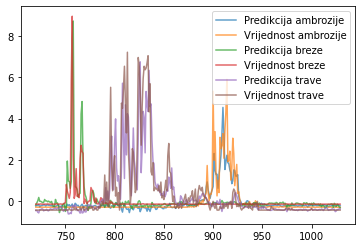

In [53]:
de = plot_predictions(model3, X_test, y_test)

In [26]:
start = 0
end = 360
start,end

(0, 360)

Text(0.5, 1.0, '2021')

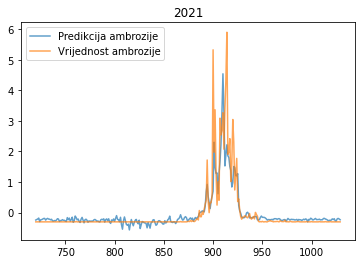

In [59]:
# PRAM
plt.plot(de['PRAM Predictions'][start:end], label = 'Predikcija ambrozije', alpha = 0.7)
plt.plot(de['PRAM Actuals'][start:end], label = 'Vrijednost ambrozije', alpha = 0.7)
plt.legend(loc="upper left")
plt.title('2021')

Text(0.5, 1.0, '2021')

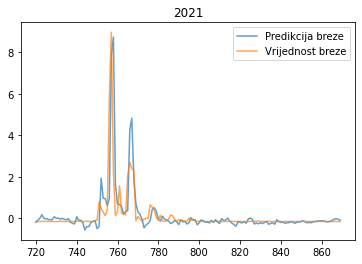

In [58]:
# PRBR
plt.plot(de['PRBR Predictions'][start:150], label = 'Predikcija breze', alpha = 0.7)
plt.plot(de['PRBR Actuals'][start:150], label = 'Vrijednost breze', alpha = 0.7)
plt.legend(loc="upper right")
plt.title('2021')

Text(0.5, 1.0, '2021')

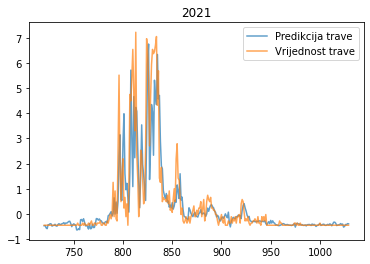

In [57]:
# PRTR
plt.plot(de['PRTR Predictions'][start:end], label = 'Predikcija trave', alpha = 0.7)
plt.plot(de['PRTR Actuals'][start:end], label = 'Vrijednost trave', alpha = 0.7)
plt.legend(loc="upper right")
plt.title('2021')